# DCGAN - TensorFlow using MNIST

### 작성자: 고려대학교 수학과 석사과정 최선묵

[References]  
- [Goodfellow's GAN Paper Link](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)  
- [DCGAN Paper Link](https://arxiv.org/pdf/1511.06434.pdf)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, tanh, sigmoid
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


## Data Preparation

In [ ]:
# Download MNIST dataset in numpy array format
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Reshape it into 4-dim'l tensor and convert the type for `int` into `float`
train_images = X_train.reshape((X_train.shape[0], 32, 32, 3)).astype('float32')
test_images = X_test.reshape((X_test.shape[0], 32, 32, 3)).astype('float32')

data_images = np.concatenate((train_images, test_images), axis=0)

# Set the pixel values from -1 to 1
data_images = (data_images/255.0) * 2 - 1

# Shuffle and seperate into batches
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(data_images).shuffle(data_images.shape[0]).batch(BATCH_SIZE)

170498071/170498071 [==============================] - 14s 0us/step


## Deep Convolutional GANs

### Architecture guidelines for stable Deep Convolutional GANs

- Replace any pooling layers with `strided convolutions` (discriminator) and `fractional-strided convolutions` (generator).
- Use `BatchNormaliziation` in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use `ReLU` activation in `generator` for all layers except for the output, which uses Tanh.
- Use `LeakyReLU` activation in the `discriminator` for all layers.

In [ ]:
## Hyperparameters
latent_dim = 100

EPOCHS = 200
LR = 2e-4
BETA1 = 0.5 # for Adam optimizer


### Generator

In [ ]:
def create_generator(input_size=latent_dim):
    input_tensor = Input(shape=(input_size))

    x = Dense(2*2*512, kernel_initializer='he_uniform')(input_tensor)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = Reshape(target_shape=(2,2,512))(x)
    x = Conv2D(256, kernel_size=(5,5), strides=1, padding='same',
               use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = Conv2DTranspose(128, kernel_size=(5,5), strides=2, padding='same',
                        use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = Conv2DTranspose(64, kernel_size=(5,5), strides=2, padding='same',
                        use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = Conv2DTranspose(16, kernel_size=(5,5), strides=2, padding='same',
                        use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.0)

    x = Conv2DTranspose(3, kernel_size=(3,3), strides=2, padding='same',
                        use_bias=True, activation='tanh', kernel_initializer='glorot_uniform')(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model

In [ ]:
g_model = create_generator()
g_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 2048)              206848    
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 256)         3276800   
                                                             

### Discriminator

In [ ]:
def create_discriminator(input_shape=(32,32,3)):

    input_tensor = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3,3), strides=2, padding='same',
               use_bias=False, kernel_initializer='he_uniform')(input_tensor)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Conv2D(64, kernel_size=(3,3), strides=2, padding='same',
               use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Conv2D(128, kernel_size=(3,3), strides=2, padding='same',
               use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = Conv2D(256, kernel_size=(3,3), strides=1, padding='same',
               use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)

    x = GlobalAveragePooling2D()(x)

    x = Dense(units=64, use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x, alpha=0.2)
    x = Dense(units=1, use_bias=True, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model

In [ ]:
d_model = create_discriminator()
d_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        864       
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 tf.nn.leaky_relu (TFOpLambd  (None, 16, 16, 32)       0         
 a)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18432     
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 64)         256 

### DCGAN model

In [ ]:
class DCGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, noise_size=latent_dim, d_iter=1):
        super(DCGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.noise_size = noise_size
        self.d_iter = d_iter

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def create_gen_input(self, batch_size, seed=None):
        noise = tf.random.normal([batch_size, self.noise_size], seed=seed)
        return noise

    def train_step(self, real_img):

        criterion = BinaryCrossentropy()
        batch_size = tf.shape(real_img)[0]

        # Train Discriminator d_iter times with fixed generator.
        with tf.GradientTape() as d_tape:
            self.discriminator.trainable = True
            self.generator.trainable = False
            d_tape.watch(self.discriminator.trainable_variables)

            # Real images have label 1 for the discriminator.
            real_label = tf.ones((batch_size, 1))

            # Create fake images
            noise = self.create_gen_input(batch_size=batch_size)
            fake_img = self.generator(noise)

            # Fake images have label 0 for the discriminator.
            fake_label = tf.zeros((batch_size, 1))

            # Compute discriminator output and its loss
            imgs   = tf.concat([real_img, fake_img], axis=0)
            labels = tf.concat([real_label, fake_label], axis=0)
            d_output = self.discriminator(imgs)
            d_loss = criterion(labels, d_output)

        # Compute gradients
        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)

        # Optimize
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Train Generator with fixed discriminator.
        with tf.GradientTape() as g_tape:
            self.discriminator.trainable = False
            self.generator.trainable = True
            g_tape.watch(self.generator.trainable_variables)

            # Train generator using fake batch images. Fake images have label 1 for generators.
            noise = self.create_gen_input(batch_size=2*batch_size)
            fake_img = self.generator(noise)
            real_label = tf.ones((2*batch_size, 1))
            d_fake_output = self.discriminator(fake_img)
            g_loss = criterion(real_label, d_fake_output)

        # Compute gradients
        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)

        # Optimize
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}



In [ ]:
gan = DCGAN(generator=g_model, discriminator=d_model)

gan.compile(d_optimizer=Adam(learning_rate=LR, beta_1 = BETA1, beta_2=0.999),
            g_optimizer=Adam(learning_rate=LR, beta_1 = BETA1, beta_2=0.999)
            )

history = gan.fit(train_dataset, epochs=EPOCHS)

Epoch 1/200
469/469 [==============================] - 44s 53ms/step - d_loss: 0.3172 - g_loss: 2.4507
Epoch 2/200
469/469 [==============================] - 24s 52ms/step - d_loss: 0.3306 - g_loss: 2.8930
Epoch 3/200
469/469 [==============================] - 25s 52ms/step - d_loss: 0.3432 - g_loss: 2.1970
Epoch 4/200
469/469 [==============================] - 24s 52ms/step - d_loss: 0.3350 - g_loss: 2.0894
Epoch 5/200
469/469 [==============================] - 24s 52ms/step - d_loss: 0.3846 - g_loss: 2.0510
Epoch 6/200
469/469 [==============================] - 25s 52ms/step - d_loss: 0.4097 - g_loss: 1.7418
Epoch 7/200
469/469 [==============================] - 24s 51ms/step - d_loss: 0.3923 - g_loss: 1.7182
Epoch 8/200
469/469 [==============================] - 24s 51ms/step - d_loss: 0.3431 - g_loss: 2.0173
Epoch 9/200
469/469 [==============================] - 24s 51ms/step - d_loss: 0.3202 - g_loss: 2.1948
Epoch 10/200
469/469 [==============================] - 24s 51ms/step - d

In [ ]:
history.history.keys()

dict_keys(['d_loss', 'g_loss'])

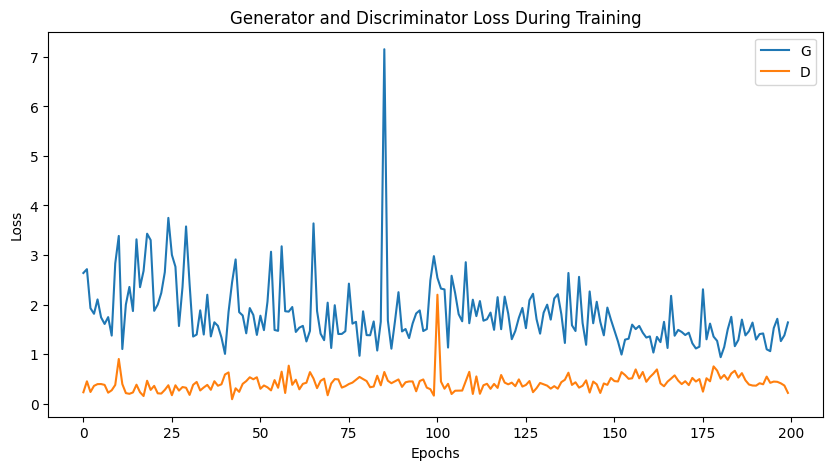

In [ ]:
d_loss = history.history['d_loss']
g_loss = history.history['g_loss']

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss,label="G")
plt.plot(d_loss,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('DCGAN_train_loss_plot.png')
plt.show()

In [ ]:
from google.colab import files

files.download('DCGAN_train_loss_plot.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save trained models

g_model.save_weights('saved_models_DCGAN/generator')
d_model.save_weights('saved_models_DCGAN/discriminator')

In [ ]:
from google.colab import files

files.download('saved_models_DCGAN/checkpoint')
files.download('saved_models_DCGAN/generator.data-00000-of-00001')
files.download('saved_models_DCGAN/generator.index')
files.download('saved_models_DCGAN/discriminator.data-00000-of-00001')
files.download('saved_models_DCGAN/discriminator.index')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load trained models

# g_model.load_weights('saved_models_DCGAN/generator')
# d_model.load_weights('saved_models_DCGAN/discriminator')

## Test

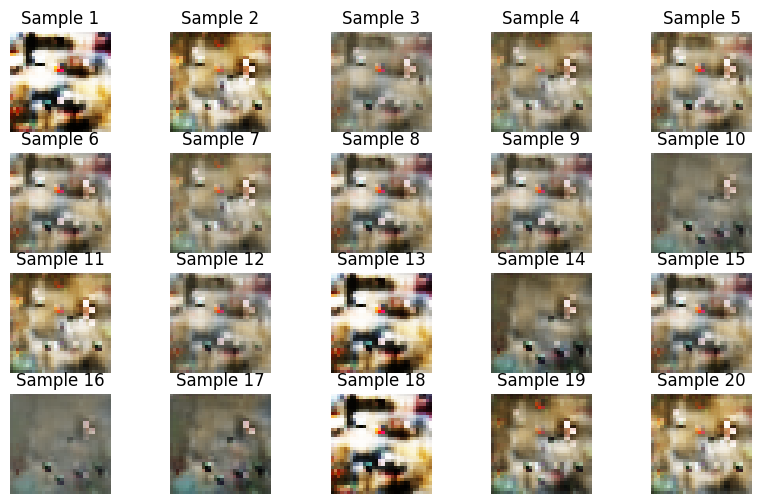

In [ ]:
noise = tf.random.normal([20, latent_dim], seed=128)
generated_images = np.array(g_model(noise))
generated_images = (generated_images + 1)/2 # convert the values from [-1,1] to [0,1] for plots

plt.rcParams['figure.figsize'] = (10.0, 6.0)

rows = 4
columns = 5

for i in range(20) :
    image_index = i+1      # image index
    title = "Sample {}".format(image_index) # image title
    plt.subplot(rows, columns, image_index) # subplot
    plt.title(title)   # title
    plt.axis('off')
    plt.xticks([])  # x = None
    plt.yticks([])  # y = None
    plt.imshow(generated_images[i])
plt.show()
